<a href="https://colab.research.google.com/github/Sylvariane/Prediction_crise_cardiaque/blob/master/Pr%C3%A9dictions_crises_cardiaques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédictions des crises cardiaques

Les maladies cardiaques sont les premières causes de décès dans le monde. Beaucoup de facteurs vont être à l'origine des maladies cardiaques.

On estime qu'environ 40.000 personnes sont victimes d'une crise cardiaque. Il existe des précurseurs des crises cardiaques comme le surpoids, la consommation de tabac ou encore l'hypertension. Ici, on s'intéresse donc à plusieurs de ces critères pour savoir lesquels peuvent permettre de prédire la survie suite à une crise cardiaque.

Dans un premier temps, une analyse exploratoire des données va être effectuée. Ensuite, à l'aide de méthode de Machine Learning, un modèle de prédiction va être créer. 

## 0. Préparation de l'environnement de travail

La première étape consiste à la mise en place de l'environnement de travail. 

In [1]:
# connexion à Google Drive pour importer le fichier
from google.colab import drive
drive.mount('/content/drive')
dir= '/content/drive/My Drive/Formation Data Analyst/Projets personnels/Heart Failure Predictions/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import ks_2samp 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
sns.set_palette("Set1")
sns.set_style('ticks')

In [4]:
dataset = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Projets personnels/Heart Failure Predictions/heart_failure_clinical_records_dataset.csv')

## 1. Analyse exploratoire des données 

On prend connaissance du jeu de données et on commence nos premières explorations.

In [5]:
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [6]:
print(dataset.shape)
print(dataset.columns)

(299, 13)
Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')


In [7]:
# traduction du nom des colonnes en français
columns = ('age', 'anémie', 'créatine kinase', 'diabète', 'fraction d\'éjection', 'hypertension', 'plaquettes', 'créatine', 'sodium', 'sexe', 'fumeur', 'suivi', 'décès')
dataset.columns = columns
print(dataset.columns)

Index(['age', 'anémie', 'créatine kinase', 'diabète', 'fraction d'éjection',
       'hypertension', 'plaquettes', 'créatine', 'sodium', 'sexe', 'fumeur',
       'suivi', 'décès'],
      dtype='object')


In [8]:
s = (dataset.dtypes == 'object')
object_cols = list(s[s].index)
print('Categorial columns :', object_cols)

Categorial columns : []


Notre jeu de données est composé de 299 lignes et 13 colonnes. Chaque ligne représente un patient et chaque colonne une caractéristique du patient. Parmi ces caractéristiques, on retrouve son âge, le fait de présenter une anémie, le taux de créatine kinase, le fait d'être diabétique, le pourcentage d'éjection du sang lors d'un battement cardiaque, le fait de souffrir d'hypertension artérielle, le nombre de plaquettes, le taux de créatinine, le taux de sodium, le sexe du patient, le fait de fumer ou non, le nombre de jours de surveillance et le décès.

On possède des données catégorielles (diabète, hypertension, *etc.*) mais les transformations ont déjà été effectuées. La prochaine étape de notre étude va être le nettoyage des données.

### 1.1. Nettoyage des données

On débute le nettoyage des données par la recherche de données manquantes.

In [9]:
dataset.isnull().sum()

age                    0
anémie                 0
créatine kinase        0
diabète                0
fraction d'éjection    0
hypertension           0
plaquettes             0
créatine               0
sodium                 0
sexe                   0
fumeur                 0
suivi                  0
décès                  0
dtype: int64

Notre jeu de données ne présente pas de données manquantes. On va ensuite s'intéresser aux données dupliquées.

In [10]:
dataset.duplicated().sum()

0

Notre jeu de données ne présente pas de données dupliquées. On peut donc passer à l'analyse exploratoire de nos données.

On crée une copie de notre dataframe pour remplacer les valeurs 0 et 1 par leurs équivalents en variables catégorielles.

In [11]:
data = dataset.copy()
data['anémie'] = data['anémie'].replace(0, 'Non')
data['diabète'] = data['diabète'].replace(0, 'Non')
data['hypertension'] = data['hypertension'].replace(0, 'Non')
data['fumeur'] = data['fumeur'].replace(0, 'Non')
data['décès'] = data['décès'].replace(0, 'Non')

data['anémie'] = data['anémie'].replace(1, 'Oui')
data['diabète'] = data['diabète'].replace(1, 'Oui')
data['hypertension'] = data['hypertension'].replace(1, 'Oui')
data['fumeur'] = data['fumeur'].replace(1, 'Oui')
data['décès'] = data['décès'].replace(1, 'Oui')

data['sexe'] = data['sexe'].replace(0, 'F')
data['sexe'] = data['sexe'].replace(1, 'M')
data.head()

,age,anémie,créatine kinase,diabète,fraction d'éjection,hypertension,plaquettes,créatine,sodium,sexe,fumeur,suivi,décès
0,75.0,Non,582,Non,20,Oui,265000.00,1.9,130,M,Non,4,Oui
1,55.0,Non,7861,Non,38,Non,263358.03,1.1,136,M,Non,6,Oui
2,65.0,Non,146,Non,20,Non,162000.00,1.3,129,M,Oui,7,Oui
3,50.0,Oui,111,Non,20,Non,210000.00,1.9,137,M,Non,7,Oui
4,65.0,Oui,160,Oui,20,Non,327000.00,2.7,116,F,Non,8,Oui


### 1.2. Analyses descriptives de nos données

#### 1.2.1. Description des données quantitatives et adéquation à la loi normale

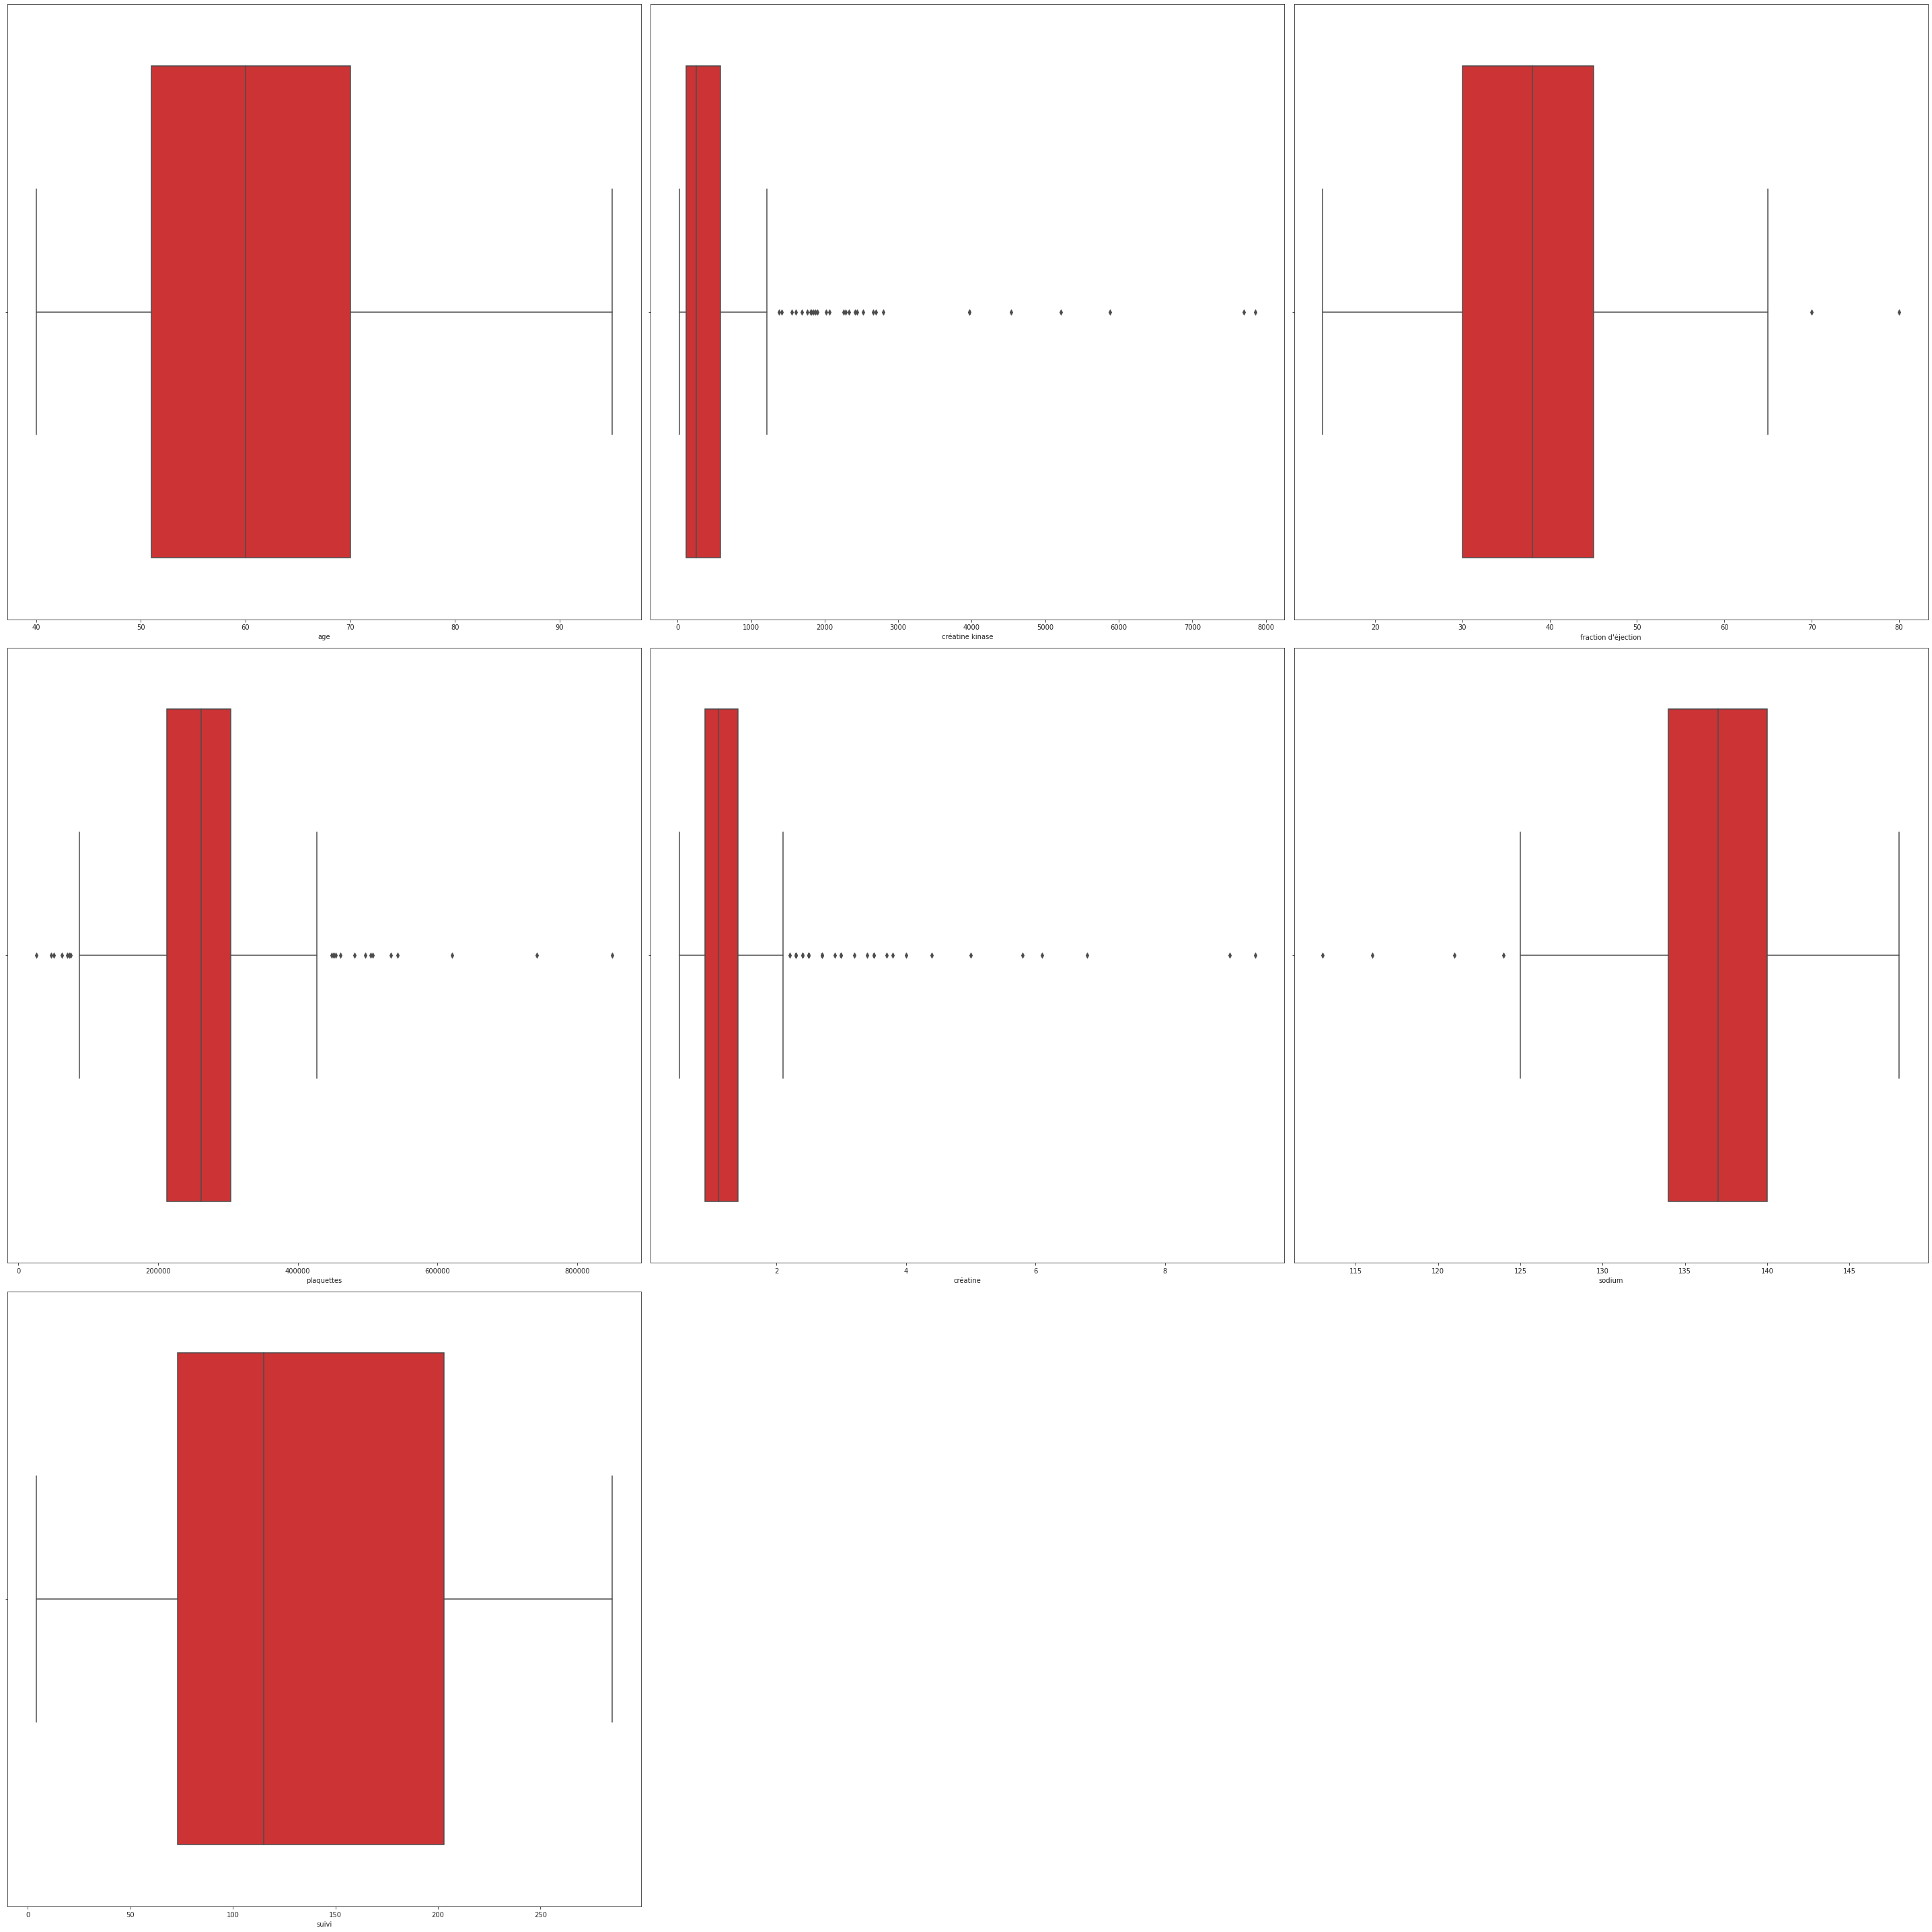

In [12]:
plt.figure(figsize = (40,40))

_ = plt.subplot(3, 3, 1)
_ = sns.boxplot('age', data=dataset)

_ = plt.subplot(3,3,2)
_ = sns.boxplot('créatine kinase', data=dataset)

_ = plt.subplot(3,3,3)
_ = sns.boxplot('fraction d\'éjection', data=dataset)

_ = plt.subplot(3,3,4)
_ = sns.boxplot('plaquettes', data=dataset)

_ = plt.subplot(3,3,5)
_ = sns.boxplot('créatine', data=dataset)

_ = plt.subplot(3,3,6)
_ = sns.boxplot('sodium', data=dataset)

_ = plt.subplot(3,3,7)
_ = sns.boxplot('suivi', data=dataset)

_ = plt.tight_layout()

_ = plt.show()

On observe deux outliers pour la fraction d'éjection.

In [13]:
outliers = data['fraction d\'éjection'] >= 70
data[outliers]

,age,anémie,créatine kinase,diabète,fraction d'éjection,hypertension,plaquettes,créatine,sodium,sexe,fumeur,suivi,décès
64,45.0,Non,582,Non,80,Non,263358.03,1.18,137,F,Non,63,Non
217,54.0,Oui,427,Non,70,Oui,151000.00,9.00,137,F,Non,196,Oui


In [14]:
data = data[~outliers]
dataset = dataset[~outliers]

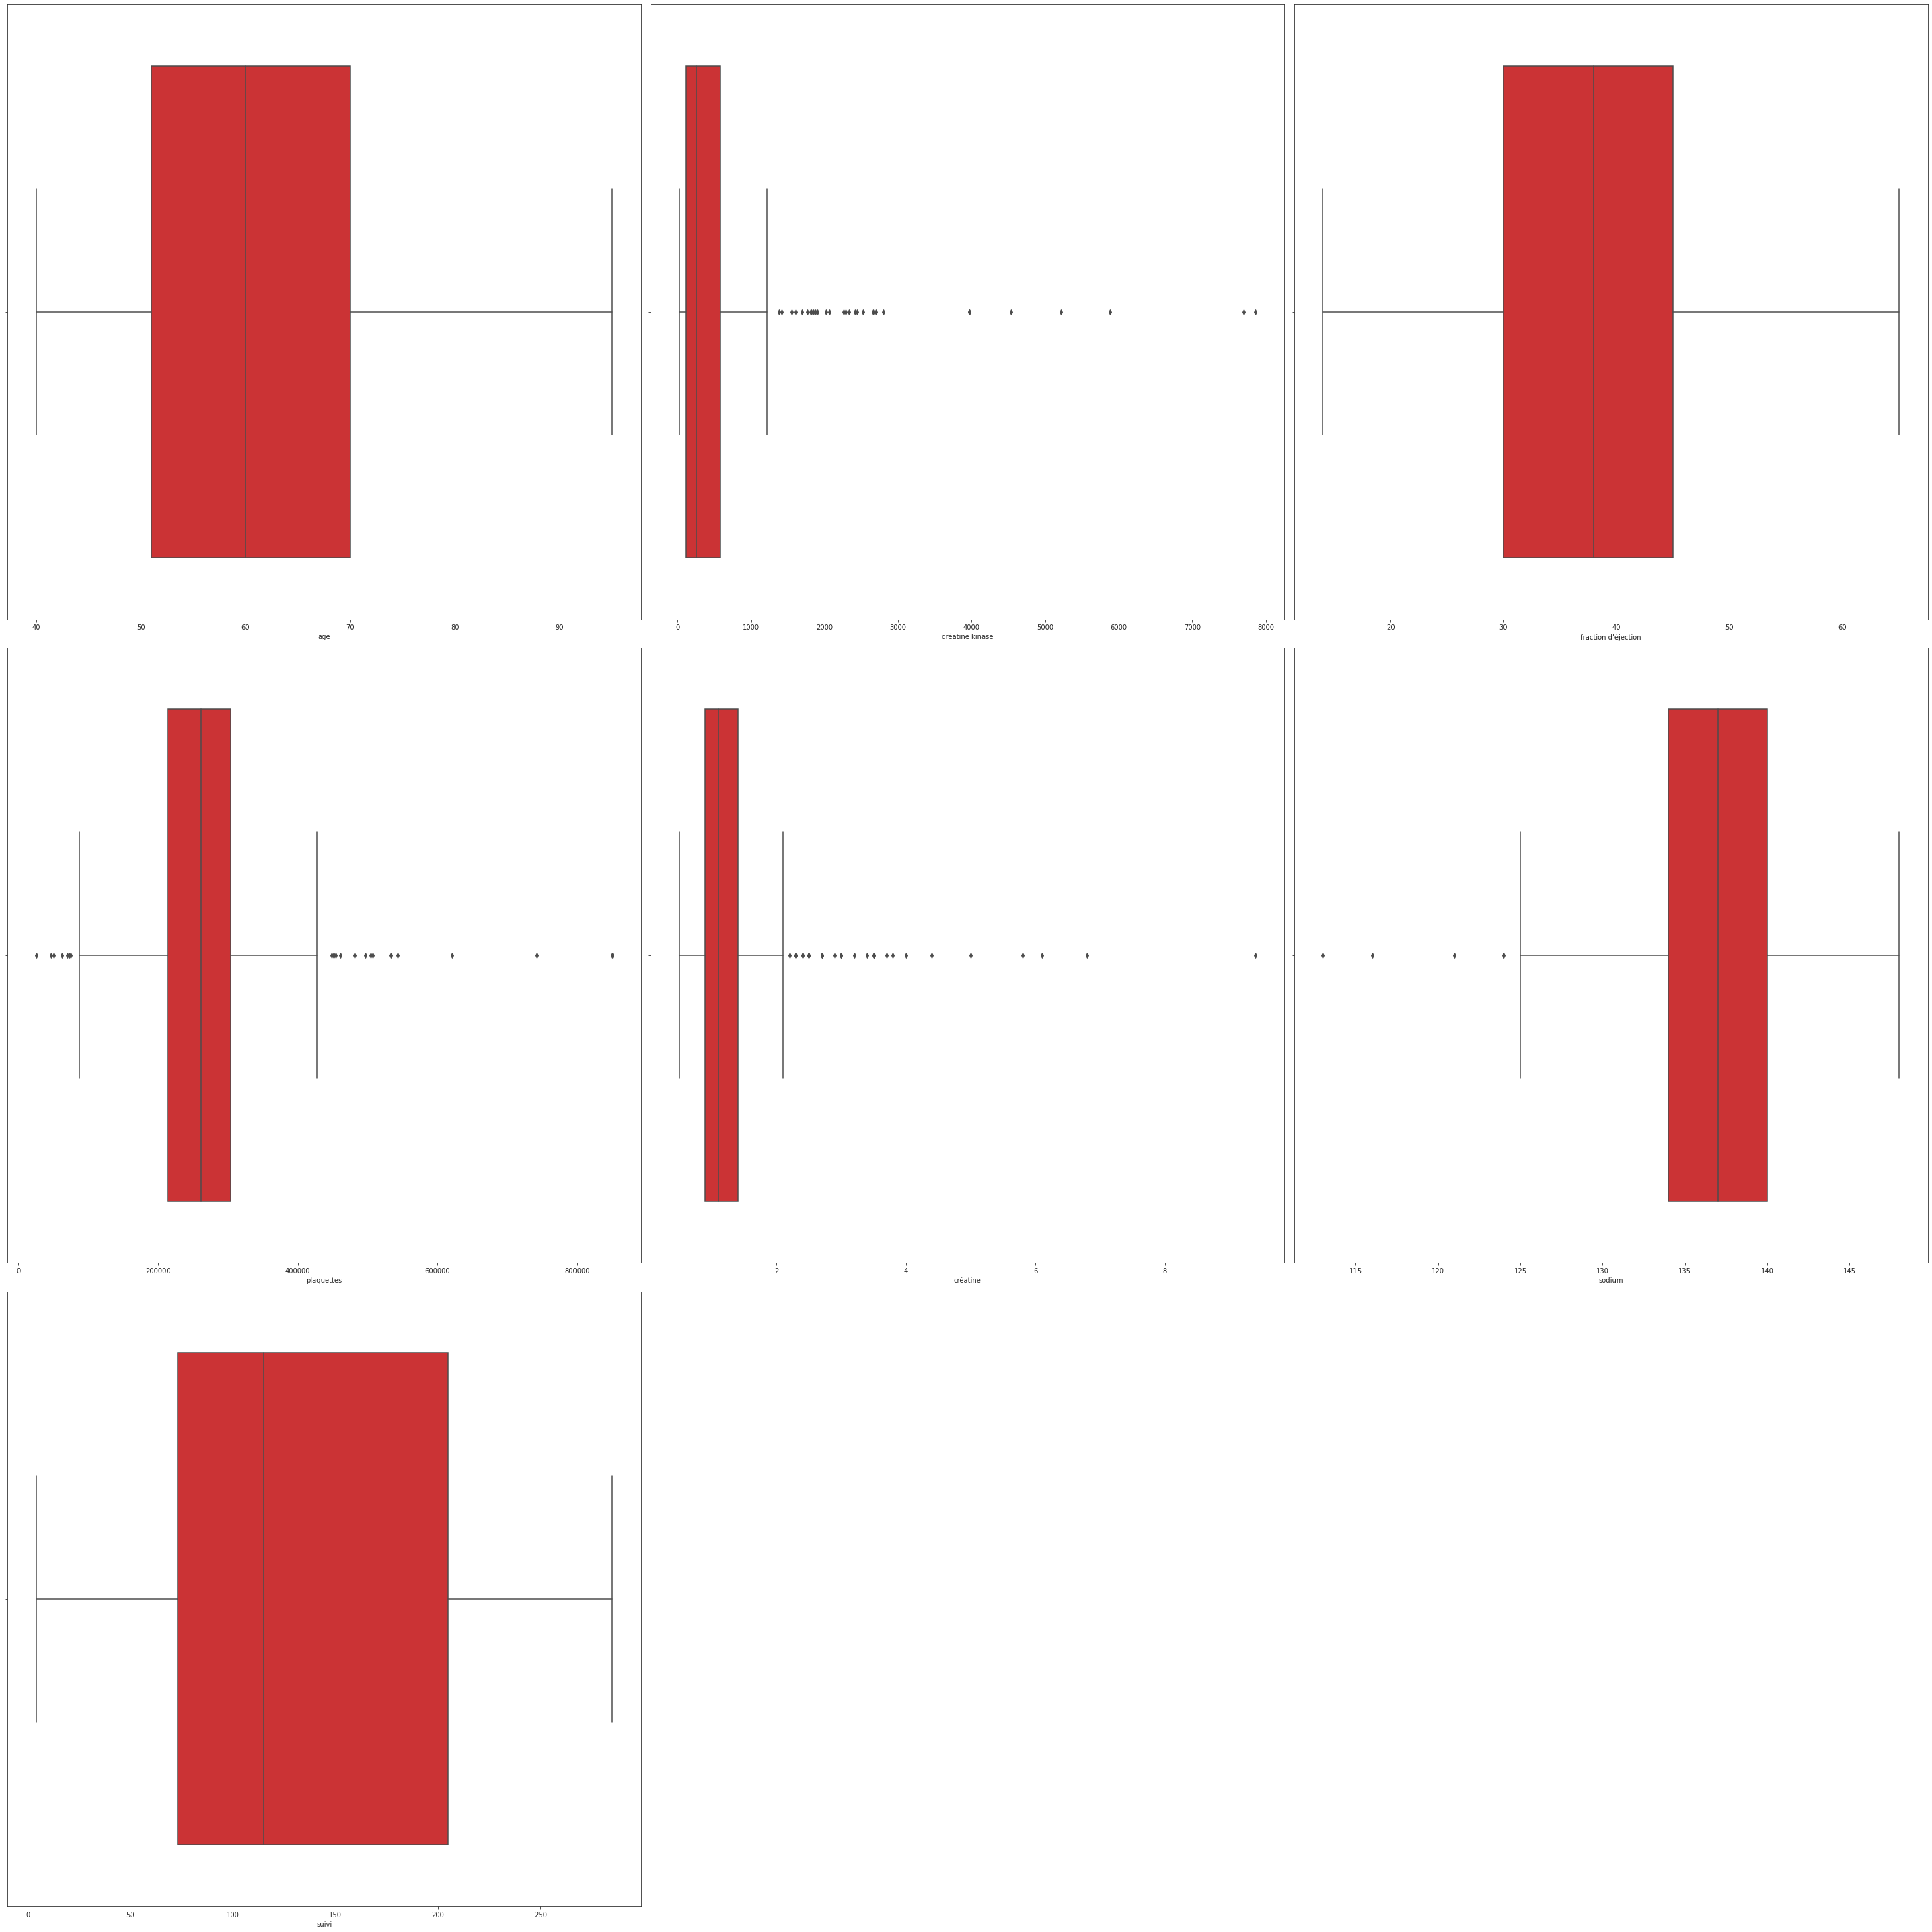

In [15]:
plt.figure(figsize = (40,40))

_ = plt.subplot(3, 3, 1)
_ = sns.boxplot('age', data=dataset)

_ = plt.subplot(3,3,2)
_ = sns.boxplot('créatine kinase', data=dataset)

_ = plt.subplot(3,3,3)
_ = sns.boxplot('fraction d\'éjection', data=dataset)

_ = plt.subplot(3,3,4)
_ = sns.boxplot('plaquettes', data=dataset)

_ = plt.subplot(3,3,5)
_ = sns.boxplot('créatine', data=dataset)

_ = plt.subplot(3,3,6)
_ = sns.boxplot('sodium', data=dataset)

_ = plt.subplot(3,3,7)
_ = sns.boxplot('suivi', data=dataset)

_ = plt.tight_layout()

_ = plt.show()

#### 1.2.2. Description des données catégorielles

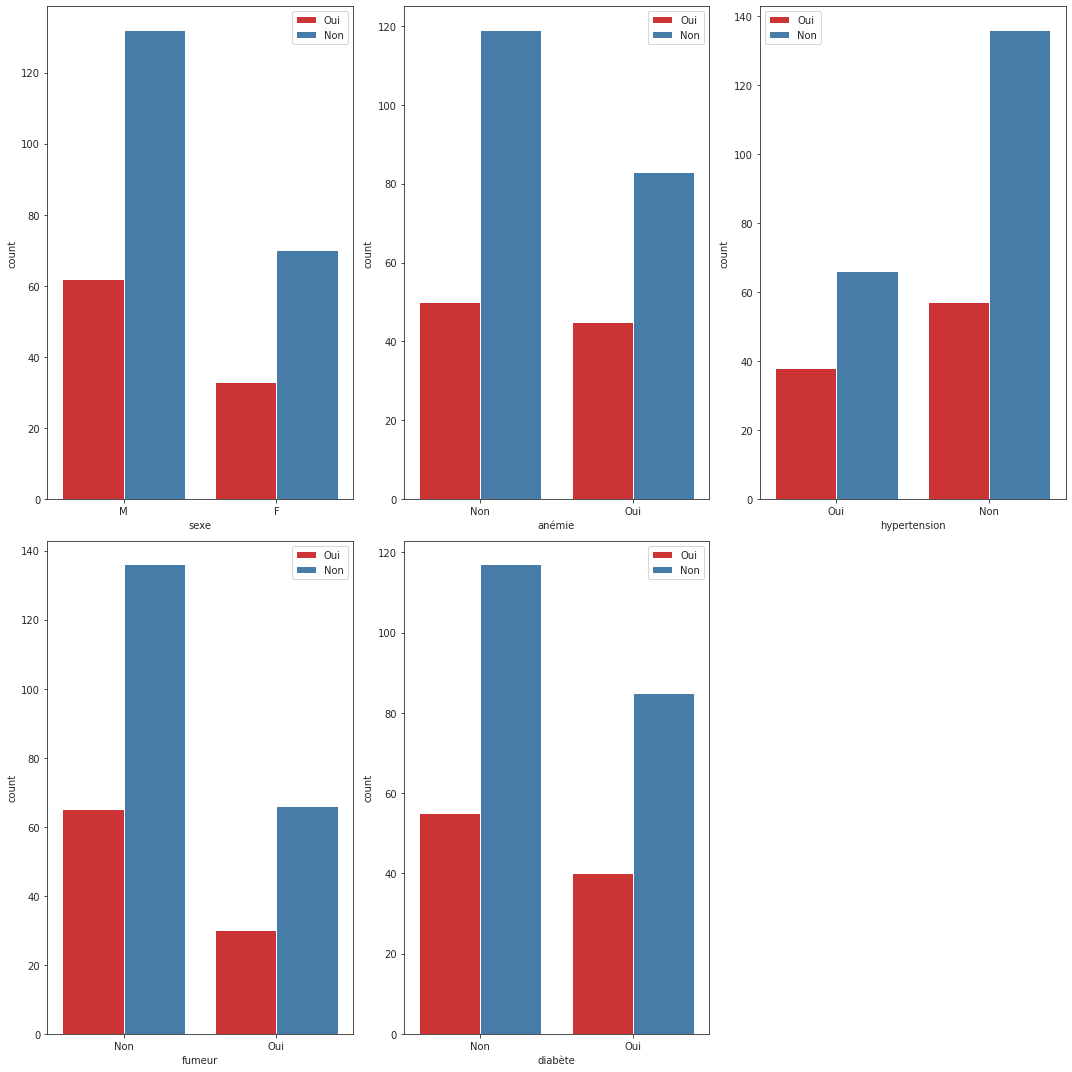

In [16]:
plt.figure(figsize = (15,15))

_ = plt.subplot(2,3,1)
_ = sns.countplot('sexe', hue='décès', data=data)
_ = plt.legend()

_ = plt.subplot(2,3,2)
_ = sns.countplot('anémie', hue='décès', data=data)
_ = plt.legend()

_ = plt.subplot(2,3,3)
_ = sns.countplot('hypertension', hue='décès', data=data)
_ = plt.legend()

_ = plt.subplot(2,3,4)
_ = sns.countplot('fumeur', hue='décès', data=data)
_ = plt.legend()

_ = plt.subplot(2,3,5)
_ = sns.countplot('diabète', hue='décès', data=data)
_ = plt.legend()

_ = plt.tight_layout()

_ = plt.show()

### 1.3. Analyses bivariées

#### 1.3.1. Corrélation sur les données catégorielles

In [17]:
X = 'sexe'
Y = 'décès'
cont = data[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len, margins=True, margins_name='Total')

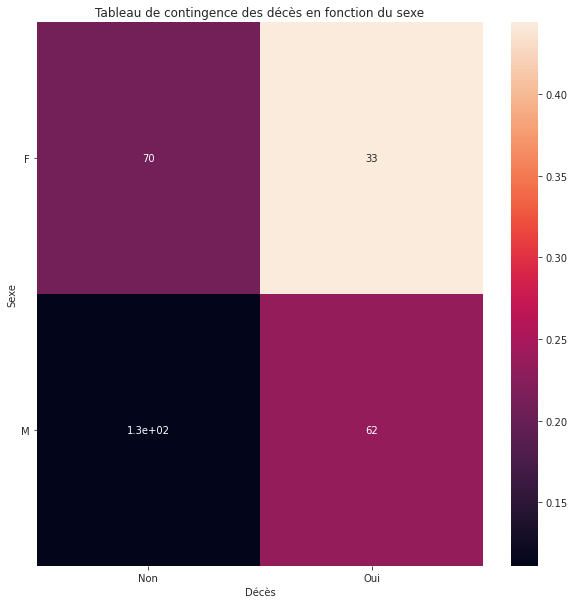

In [18]:
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

_ = plt.figure(figsize = (10,10))
_ = sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
_ = plt.xlabel('Décès')
_ = plt.ylabel('Sexe')
_ = plt.yticks(rotation = 360)
_ = plt.title('Tableau de contingence des décès en fonction du sexe')

_ = plt.show()

In [19]:
print('xi_n : ', xi_n)

st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
print('chi-squared :', st_chi2)
print('p-value :', st_p)

xi_n :  0.00019828163220792492
chi-squared : 0.00019828163220792492
p-value : 0.9999999950858741


In [20]:
X = 'fumeur'
Y = 'décès'
cont = data[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len, margins=True, margins_name='Total')

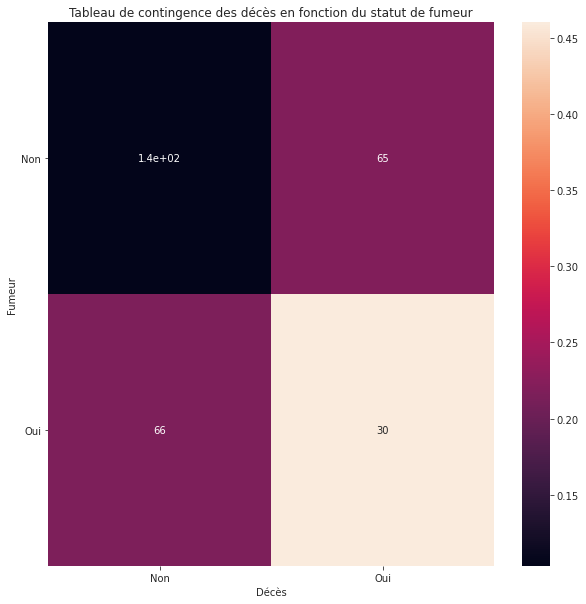

In [21]:
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

_ = plt.figure(figsize = (10,10))
_ = sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
_ = plt.xlabel('Décès')
_ = plt.ylabel('Fumeur')
_ = plt.yticks(rotation = 360)
_ = plt.title('Tableau de contingence des décès en fonction du statut de fumeur')

_ = plt.show()

In [22]:
print('xi_n : ', xi_n)

st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
print('chi-squared :', st_chi2)
print('p-value :', st_p)

xi_n :  0.03537144268236733
chi-squared : 0.03537144268236733
p-value : 0.9998454393997448


In [23]:
X = 'anémie'
Y = 'décès'
cont = data[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len, margins=True, margins_name='Total')

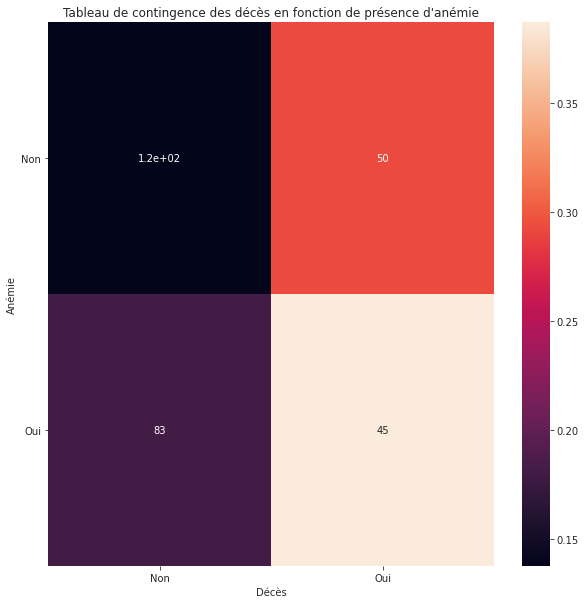

In [24]:
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

_ = plt.figure(figsize = (10,10))
_ = sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
_ = plt.xlabel('Décès')
_ = plt.ylabel('Anémie')
_ = plt.yticks(rotation = 360)
_ = plt.title('Tableau de contingence des décès en fonction de présence d\'anémie')

_ = plt.show()

In [25]:
print('xi_n : ', xi_n)

st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
print('chi-squared :', st_chi2)
print('p-value :', st_p)

xi_n :  1.03886447200758
chi-squared : 1.03886447200758
p-value : 0.9038467115208269


In [26]:
X = 'hypertension'
Y = 'décès'
cont = data[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len, margins=True, margins_name='Total')

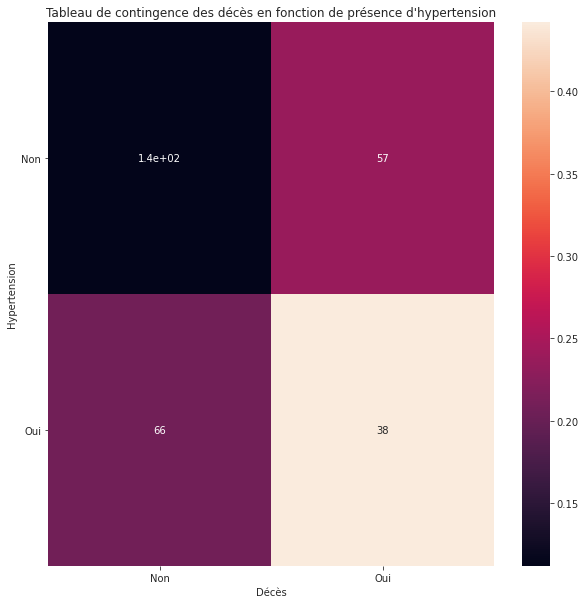

In [27]:
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

_ = plt.figure(figsize = (10,10))
_ = sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
_ = plt.xlabel('Décès')
_ = plt.ylabel('Hypertension')
_ = plt.yticks(rotation = 360)
_ = plt.title('Tableau de contingence des décès en fonction de présence d\'hypertension')

_ = plt.show()

In [28]:
print('xi_n : ', xi_n)

st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
print('chi-squared :', st_chi2)
print('p-value :', st_p)

xi_n :  1.5242684750738924
chi-squared : 1.5242684750738924
p-value : 0.8223340923064364


In [29]:
X = 'diabète'
Y = 'décès'
cont = data[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len, margins=True, margins_name='Total')

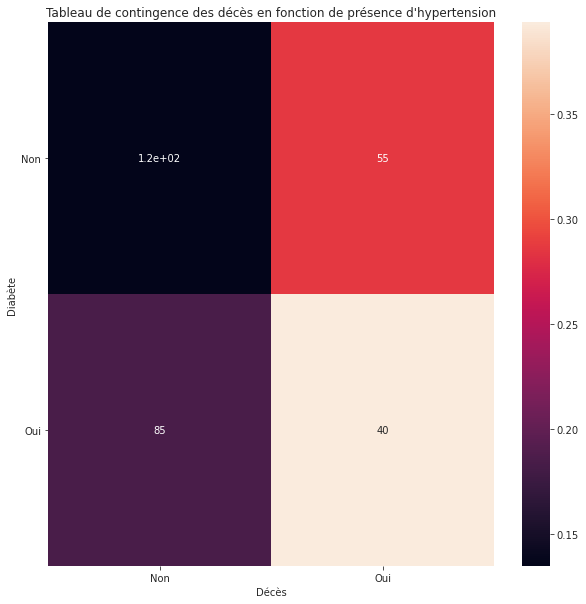

In [30]:
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

_ = plt.figure(figsize = (10,10))
_ = sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
_ = plt.xlabel('Décès')
_ = plt.ylabel('Diabète')
_ = plt.yticks(rotation = 360)
_ = plt.title('Tableau de contingence des décès en fonction de présence d\'hypertension')

_ = plt.show()

In [31]:
print('xi_n : ', xi_n)

st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
print('chi-squared :', st_chi2)
print('p-value :', st_p)

xi_n :  1.7996291673231993e-05
chi-squared : 1.7996291673231993e-05
p-value : 0.9999999999595169


#### 1.3.2. Corrélation sur les données quantitatives

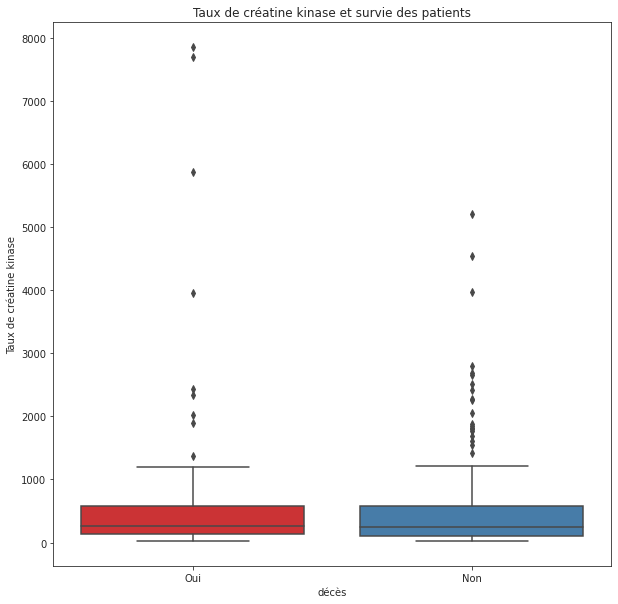

In [32]:
plt.figure(figsize=[10,10])

_ = sns.boxplot(x='décès', y='créatine kinase', data=data)
_ = plt.ylabel('Taux de créatine kinase')
_ = plt.title('Taux de créatine kinase et survie des patients')

_ = plt.show()

In [33]:
X = data['décès'] # qualitative
Y = data['créatine kinase']

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print('eta-squared :', eta_squared(X,Y))

eta-squared : 0.004068763918542349


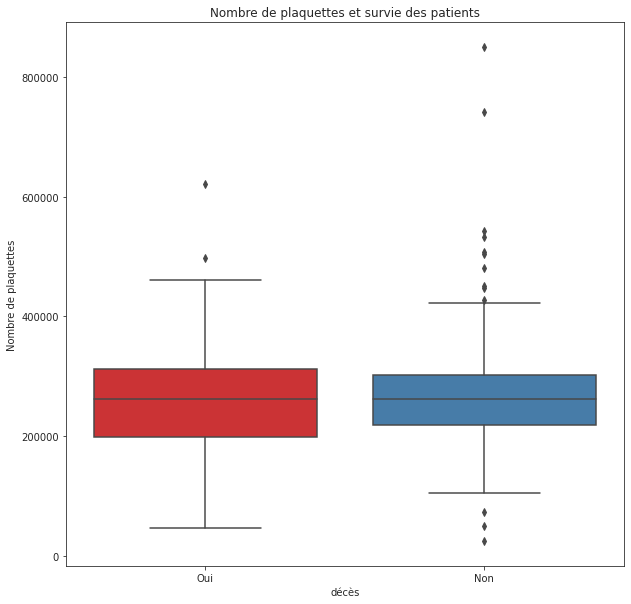

In [34]:
plt.figure(figsize=[10,10])

_ = sns.boxplot(x='décès', y='plaquettes', data=data)
_ = plt.ylabel('Nombre de plaquettes')
_ = plt.title('Nombre de plaquettes et survie des patients')

_ = plt.show()

In [35]:
X = data['décès'] # qualitative
Y = data['plaquettes']

print('eta-squared :', eta_squared(X,Y))

eta-squared : 0.001920162514944191


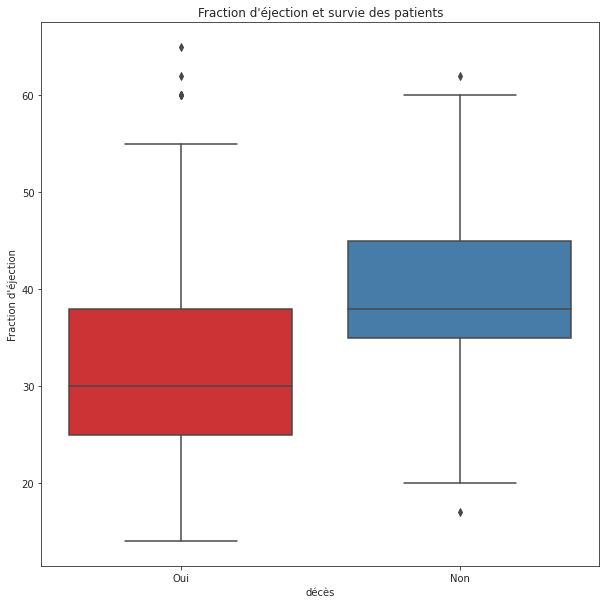

In [36]:
plt.figure(figsize=[10,10])

_ = sns.boxplot(x='décès', y='fraction d\'éjection', data=data)
_ = plt.ylabel('Fraction d\'éjection')
_ = plt.title('Fraction d\'éjection et survie des patients')

_ = plt.show()

In [37]:
X = data['décès'] # qualitative
Y = data['fraction d\'éjection']

print('eta-squared :', eta_squared(X,Y))

eta-squared : 0.08094920066919595


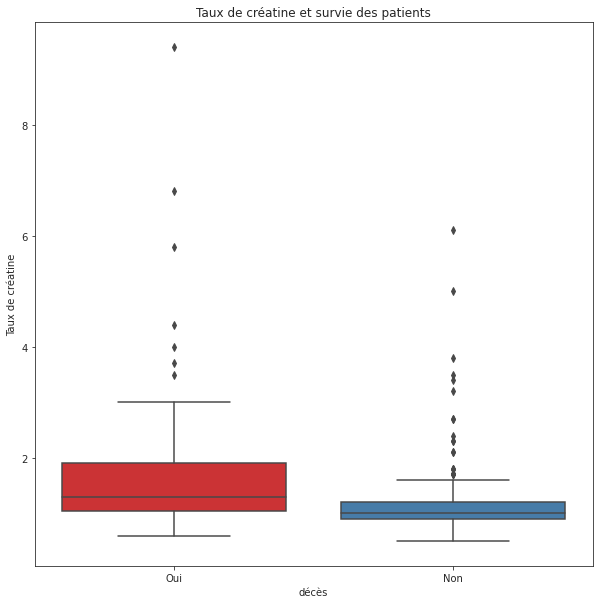

In [38]:
plt.figure(figsize=[10,10])

_ = sns.boxplot(x='décès', y='créatine', data=data)
_ = plt.ylabel('Taux de créatine')
_ = plt.title('Taux de créatine et survie des patients')

_ = plt.show()

In [39]:
X = data['décès'] # qualitative
Y = data['créatine']

print('eta-squared :', eta_squared(X,Y))

eta-squared : 0.08204745374897847


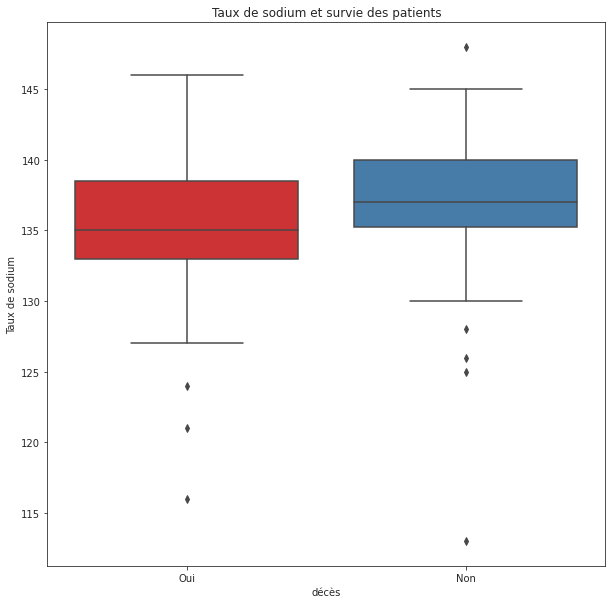

In [40]:
plt.figure(figsize=[10,10])

_ = sns.boxplot(x='décès', y='sodium', data=data)
_ = plt.ylabel('Taux de sodium')
_ = plt.title('Taux de sodium et survie des patients')

_ = plt.show()

In [41]:
X = data['décès'] # qualitative
Y = data['sodium']

print('eta-squared :', eta_squared(X,Y))

eta-squared : 0.03852567551849872


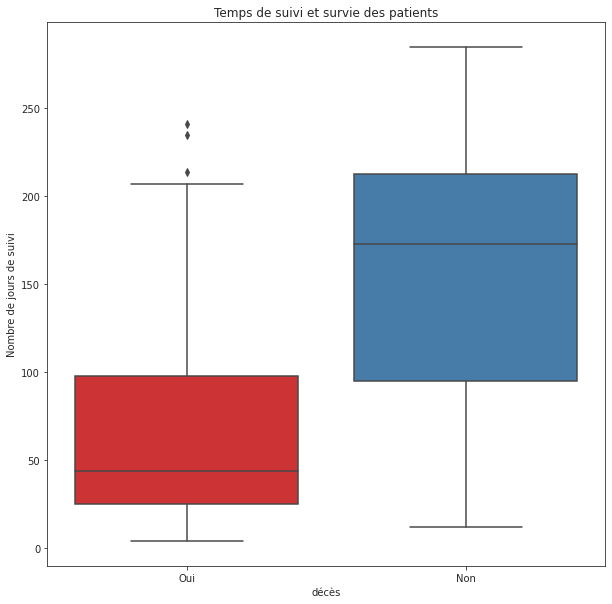

In [42]:
plt.figure(figsize=[10,10])

_ = sns.boxplot(x='décès', y='suivi', data=data)
_ = plt.ylabel('Nombre de jours de suivi')
_ = plt.title('Temps de suivi et survie des patients')

_ = plt.show()

In [43]:
X = data['décès'] # qualitative
Y = data['suivi']

print('eta-squared :', eta_squared(X,Y))

eta-squared : 0.28808318087460777


#### 1.3.3. Matrice de corrélation globale

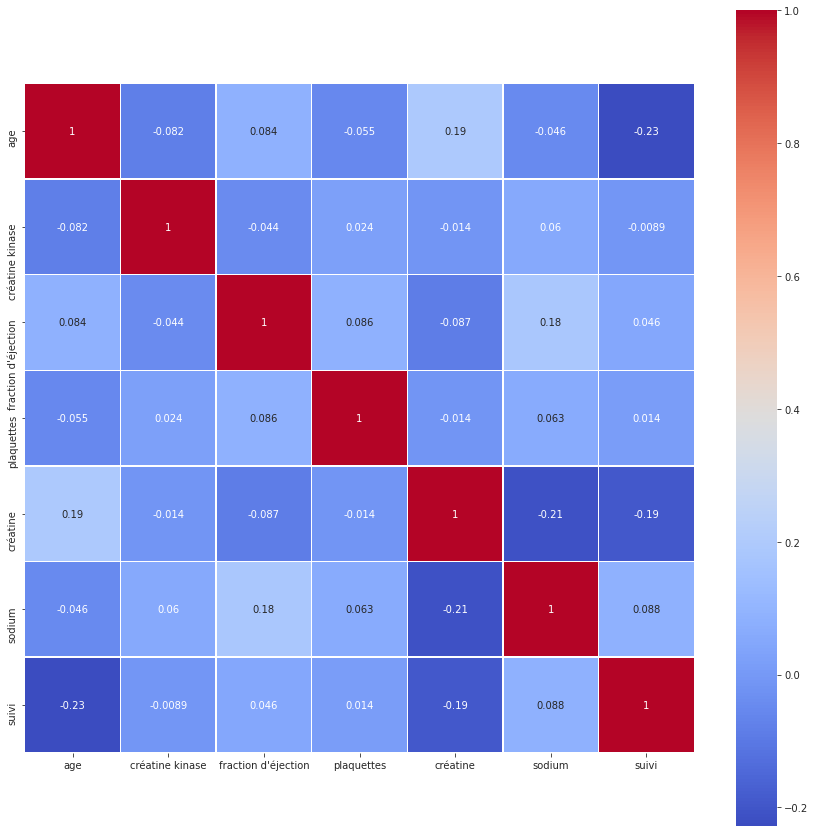

In [44]:
corrMatrix = data.corr()
plt.figure(figsize=(15,15))
_ = sns.heatmap(corrMatrix,square = True, cmap="coolwarm",linewidths=.5, annot=True)
_ = plt.show()

## 2. Modélisation et Machine Learning

In [45]:
X = dataset[['age','fraction d\'éjection','créatine', 'sodium', 'suivi']]
y = dataset['décès']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size = 0.8, random_state=1)

### 2.1. Random Forest

In [47]:
rf = RandomForestClassifier(max_depth=2, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Taux de précision : ', metrics.accuracy_score(y_pred=y_pred,y_true=y_test) * 100, '%')

Taux de précision :  86.66666666666667 %


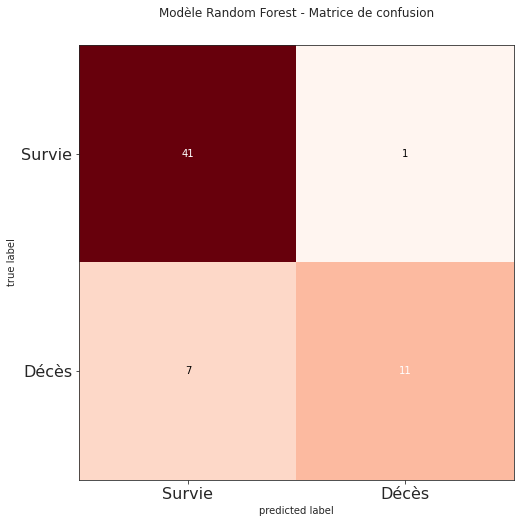

In [48]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Reds)
_ = plt.title("Modèle Random Forest - Matrice de confusion")
_ = plt.xticks(range(2), ["Survie","Décès"], fontsize=16)
_ = plt.yticks(range(2), ["Survie","Décès"], fontsize=16)
_ = plt.show()

Text(0.5, 0, 'Relative Importance')

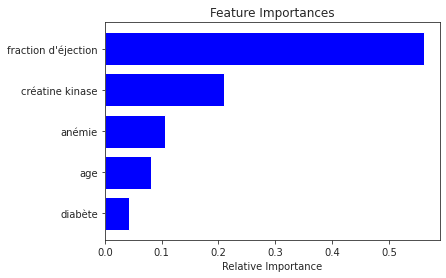

In [49]:
importances = rf.feature_importances_
indices = np.argsort(importances)
 
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [dataset.columns[i] for i in indices])
plt.xlabel('Relative Importance')

### 2.2. Gradient Boosting

In [50]:
gbc = GradientBoostingClassifier(max_depth=2, random_state=42)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

print('Taux de précision : ', metrics.accuracy_score(y_pred=y_pred,y_true=y_test) * 100, '%')

Taux de précision :  81.66666666666667 %


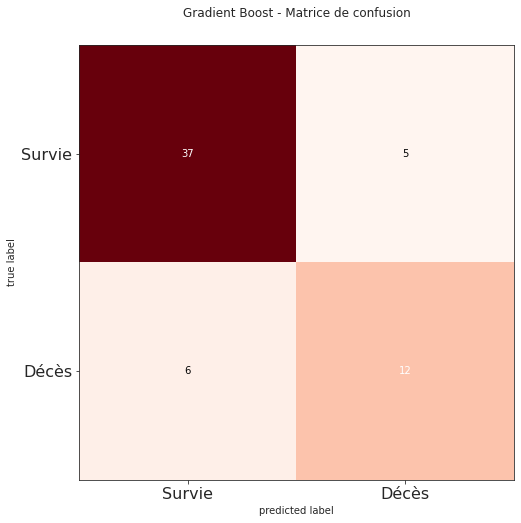

In [51]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Reds)
plt.title("Gradient Boost - Matrice de confusion")
plt.xticks(range(2), ["Survie","Décès"], fontsize=16)
plt.yticks(range(2), ["Survie","Décès"], fontsize=16)
plt.show()

Text(0.5, 0, 'Relative Importance')

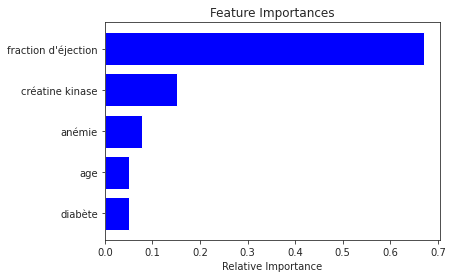

In [54]:
importances = gbc.feature_importances_
indices = np.argsort(importances)
 
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [dataset.columns[i] for i in indices])
plt.xlabel('Relative Importance')

### 2.3. AdaBoost

In [52]:
adc = AdaBoostClassifier(n_estimators=100, random_state=42)
adc.fit(X_train, y_train)
y_pred = adc.predict(X_test)

print('Taux de précision : ', metrics.accuracy_score(y_pred=y_pred,y_true=y_test) * 100, '%')

Taux de précision :  78.33333333333333 %


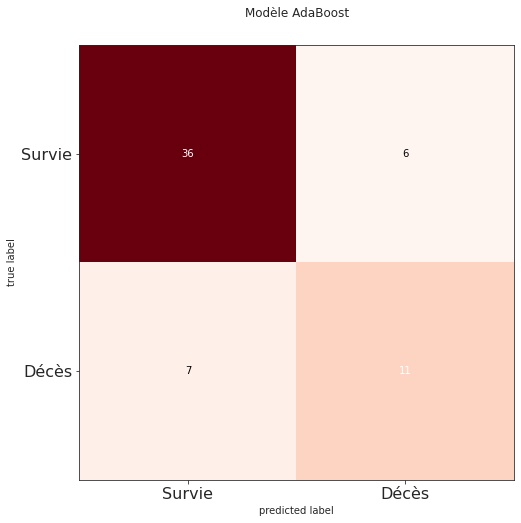

In [53]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Reds)
plt.title("Modèle AdaBoost")
plt.xticks(range(2), ["Survie","Décès"], fontsize=16)
plt.yticks(range(2), ["Survie","Décès"], fontsize=16)
plt.show()

Text(0.5, 0, 'Relative Importance')

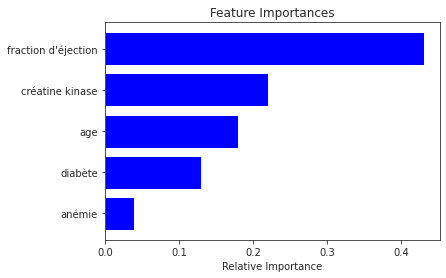

In [55]:
importances = adc.feature_importances_
indices = np.argsort(importances)
 
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [dataset.columns[i] for i in indices])
plt.xlabel('Relative Importance')

Parmi nos 3 modèles de classification, la méthode de la random forest est celui qui obtient un plus haut pourcentage de précision (85%). Les autres modèles obtiennent de bons pourcentage de précision. Cependant la méthode de la random forest est celle qui produit le moins de faux négatif.

Quelle que soit nos modèles, on remarque que la fraction d'éjection est la variable prédictive qui va avoir le plus d'importance dans les chances de survie chez les patients. 

Sources : 
- https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181001
- https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5
- https://www.fedecardio.org/Les-gestes-qui-sauvent/L-arret-cardiaque/larret-cardiaque-un-bilan-alarmant
- https://www.who.int/fr/news-room/fact-sheets/detail/the-top-10-causes-of-death
